In [1]:
%pip install -q --upgrade keras keras-cv tensorflow openpyxl tensorflow_datasets setuptools scikit-learn segmentation-models matplotlib opencv-python seaborn keras_tuner pandas
print("Successfully installed required packages.")


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import shutil

import tensorflow as tf
import keras
import keras_cv

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

from kfold import copy_files_to_fold, fold_segmented_classification
from evaluations import visualize_confusion_matrices, visualize_history_val_loss, plot_loss_curve, plot_confusion_matrix
import load_model
import gradcam
import keras_tuner
import openpyxl

2024-08-31 19:27:24.949095: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-31 19:27:24.960876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 19:27:24.974057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 19:27:24.977935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 19:27:24.987821: I tensorflow/core/platform/cpu_feature_guar

In [2]:
split_dir = './segmented_classification/split'

def split_dataset(base_split_dir='./segmented_classification/split', segmented_classification_dir='segmented_classification/overlayed_out', oversampling=False, undersampling=False):
    train_split = 'train'
    test_split = 'test'
    splits = [train_split, test_split]
    normal_class = 'normal'
    tb_class = 'tuberculosis'
    classes = [normal_class, tb_class]

    all_files = [f for f in os.listdir(segmented_classification_dir) if os.path.isfile(os.path.join(segmented_classification_dir, f))]
    normal_files = [f for f in all_files if 'Normal' in f]
    tb_files = [f for f in all_files if 'Tuberculosis' in f]

    if undersampling == True:
        print('Oversampling selected... Setting number of normal samples to: %d' % len(tb_files))
        normal_files = normal_files[:len(tb_files)]

    if os.path.exists(base_split_dir):
        print("Removing existing dataset")
        # If the split directory exists, remove it and so it can be regenerated
        shutil.rmtree(base_split_dir)

    # Split the data into training, test sets
    # The validation set will be created from the training set at a later stage
    train_normal, test_normal = train_test_split(normal_files, test_size=0.1)
    train_tb, test_tb = train_test_split(tb_files, test_size=0.1)

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(base_split_dir, split, cls), exist_ok=True)

    def append_filename_suffix(filename, suffix):
        spl = filename.split('.')
        spl[0] += suffix
        return '.'.join(spl)

    # Function to copy files to their respective directories
    def copy_files(file_list, dst_dir, file_suffix=None):
        for file in file_list:
            src_dir = segmented_classification_dir
            if file_suffix:
                shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, append_filename_suffix(file, file_suffix)))
            else:
                shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

    print("Copying train normal set...")
    copy_files(train_normal, os.path.join(base_split_dir, train_split, normal_class))
    print("Copying test normal set...")
    copy_files(test_normal, os.path.join(base_split_dir, test_split, normal_class))

    if oversampling == True:
        for i in range(int(len(train_normal) / len(train_tb) - 1)):
            print("Copying train tb set (%d)..." % (i + 1))
            copy_files(train_tb, os.path.join(base_split_dir, train_split, tb_class), file_suffix='_%d' % i)
    else:
        print("Copying train tb set...")
        copy_files(train_tb, os.path.join(base_split_dir, train_split, tb_class))
    print("Copying test tb set...")
    copy_files(test_tb, os.path.join(base_split_dir, test_split, tb_class))

split_dataset(base_split_dir=split_dir)

Removing existing dataset
Copying train normal set...


Copying test normal set...
Copying train tb set...
Copying test tb set...


In [3]:
# ~~~~~~~~~~~~~~~~~~~~~ Training ~~~~~~~~~~~~~~~~~~~~~
def build_model():
    regularisation_value = 0.001
    model = keras.Sequential([
        keras.layers.InputLayer(shape=(256, 256, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.MaxPooling2D(pool_size=2, strides=2),
        keras.layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.MaxPooling2D(pool_size=2, strides=2),
        keras.layers.Conv2D(256, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.Conv2D(256, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.Conv2D(128, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.MaxPooling2D(pool_size=2, strides=2),
        keras.layers.Conv2D(128, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.Flatten(),
        keras.layers.Dense(
            4096,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal(),
            kernel_regularizer=keras.regularizers.L2(regularisation_value)
        ),
        keras.layers.Dense(
            4096,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal(),
            kernel_regularizer=keras.regularizers.L2(regularisation_value)
        ),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001,
            beta_1=0.95
        ),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            'precision',
            'recall',
            keras.metrics.AUC()
        ]
    )

    return model

histories = []
predictions = []
y_true = []

ckpt_dir = 'models/segmented_undersampling/ckpt'
results_dir = 'results/segmented_undersampling'

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 1),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=10/11,
)

def apply_training_augment(images, labels):
    images = images / 255
    images = rand_augment(images)
    return images, labels

def apply_validation_normalisation(images, labels):
    return images / 255, labels

# This first if statement is to check if we already have the results
# for this model
if os.path.exists(os.path.join(results_dir, 'results.json')) == False:
    # If we do NOT have the results we need to ensure that we
    # remove the existing saved models before continuing
    if os.path.exists(ckpt_dir):
        shutil.rmtree(ckpt_dir)

    split, filenames, y = fold_segmented_classification(undersampling=True)
    for i, (train_idx, test_idx) in enumerate(split):
        # This block ensures that the epoch with the lowest validation loss
        # Is used for evaluation. While not perfect, it should be good enough
        # when using it over 5 folds.
        checkpoint_filepath = '%s/%d-checkpoint.model.keras' % (ckpt_dir, i)
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            start_from_epoch=10,
            patience=5,
            restore_best_weights=True
        )
        tensorboard_cb = keras.callbacks.TensorBoard('tensorboard/classification/segmented_undersampling/fold-%d' % i)

        train = filenames[train_idx]
        test = filenames[test_idx]
        copy_files_to_fold(train, test)

        # 10% of the test dataset will be used for validation
        train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/train',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            validation_split=0.1,
            subset='both',
            seed=42
        )

        train_dataset = train_dataset.map(apply_training_augment, num_parallel_calls=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        test_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/test',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            shuffle=False
        )
        test_dataset = test_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        model = build_model()
        history = model.fit(
            train_dataset,
            epochs=50,
            validation_data=validation_dataset,
            callbacks=[model_checkpoint_callback, early_stopping, tensorboard_cb]
        )

        histories.append(history)
        predictions.append(model.predict(test_dataset))
        y_true.append(np.concatenate([y for _, y in test_dataset], axis=0).astype(int))

    load_model.save_results(results_dir, histories, predictions, y_true)

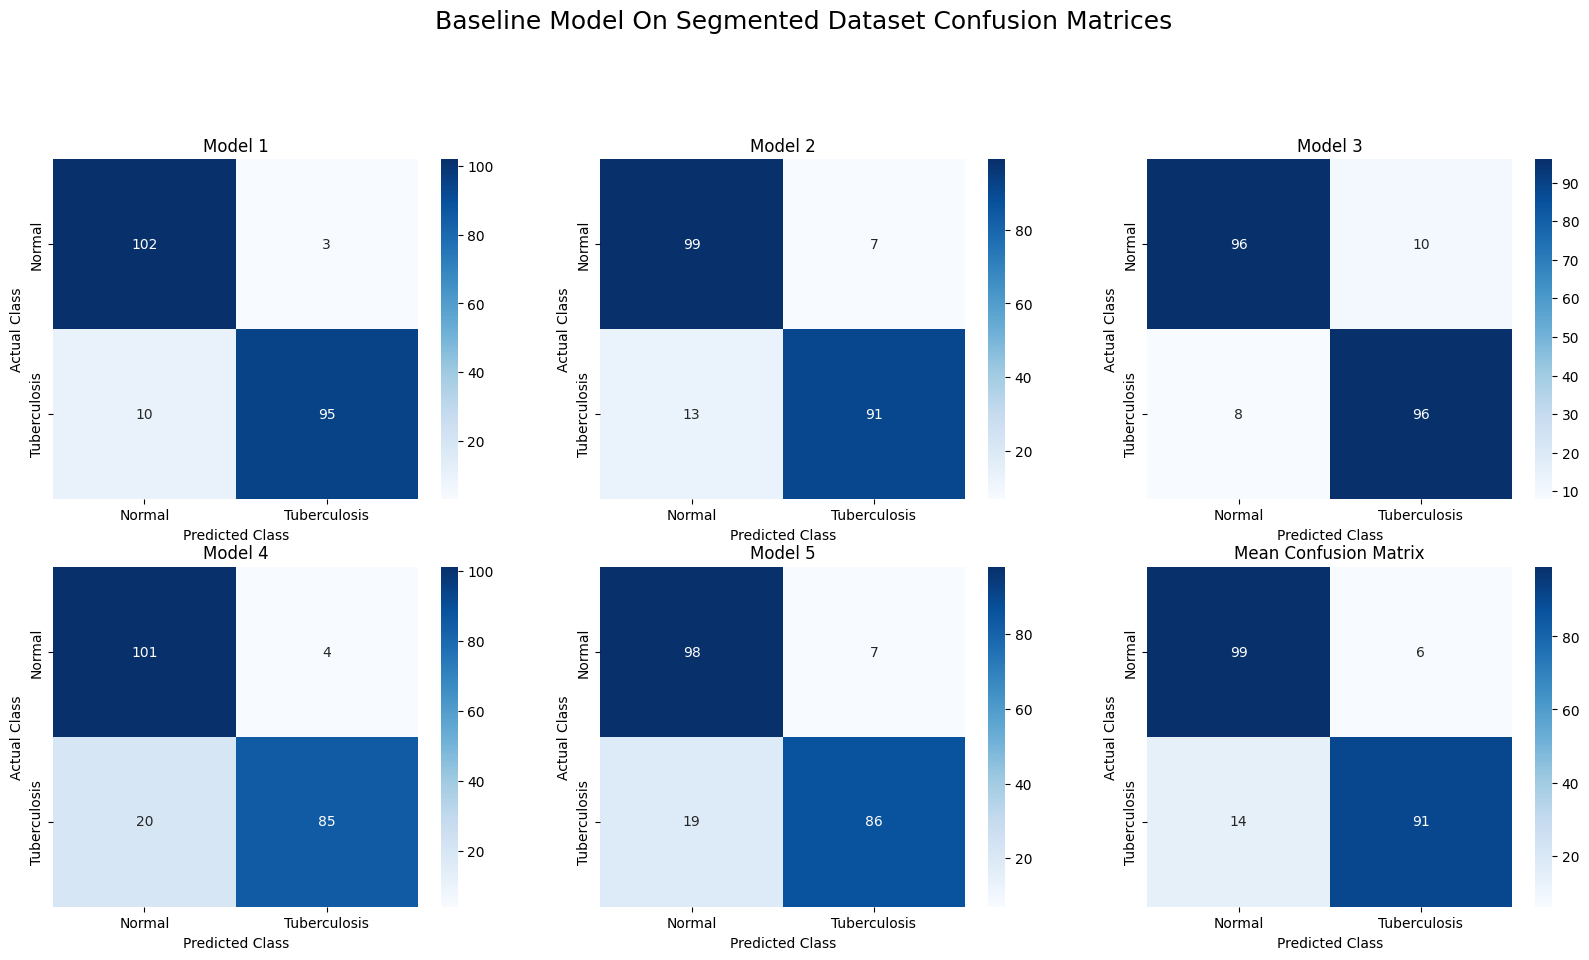

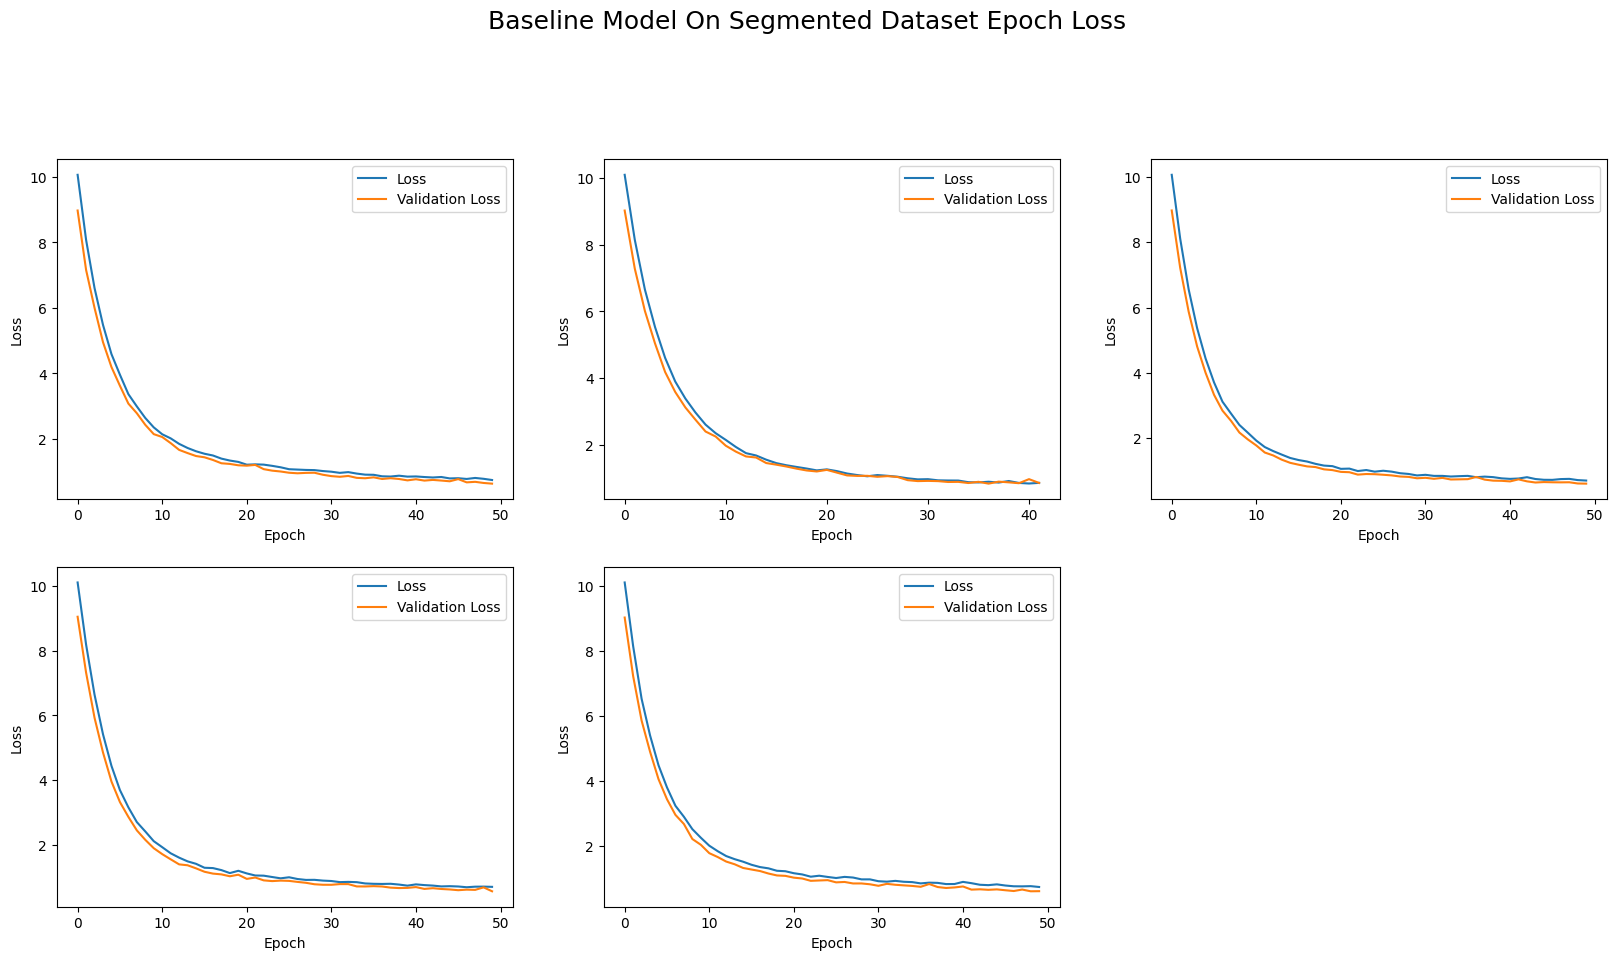

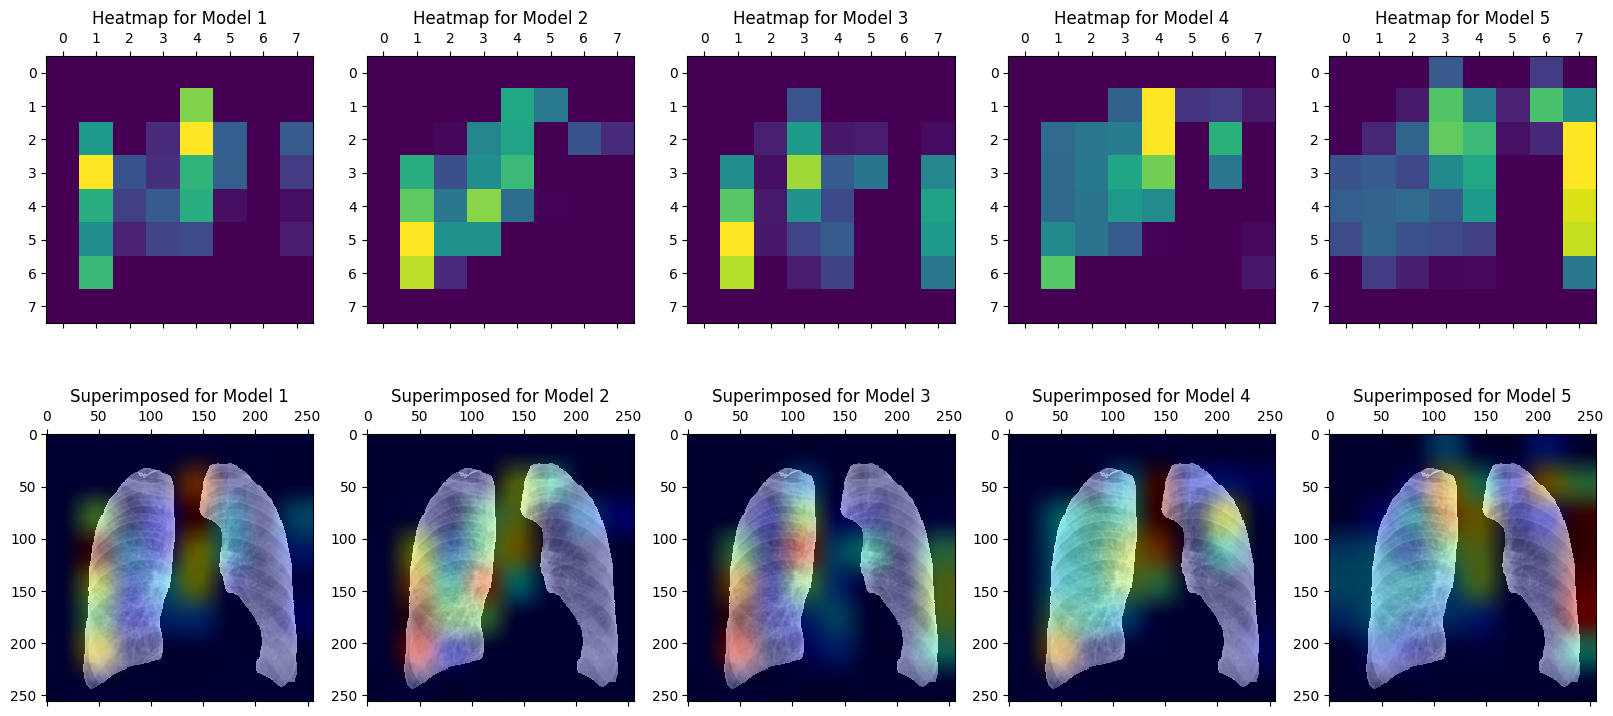

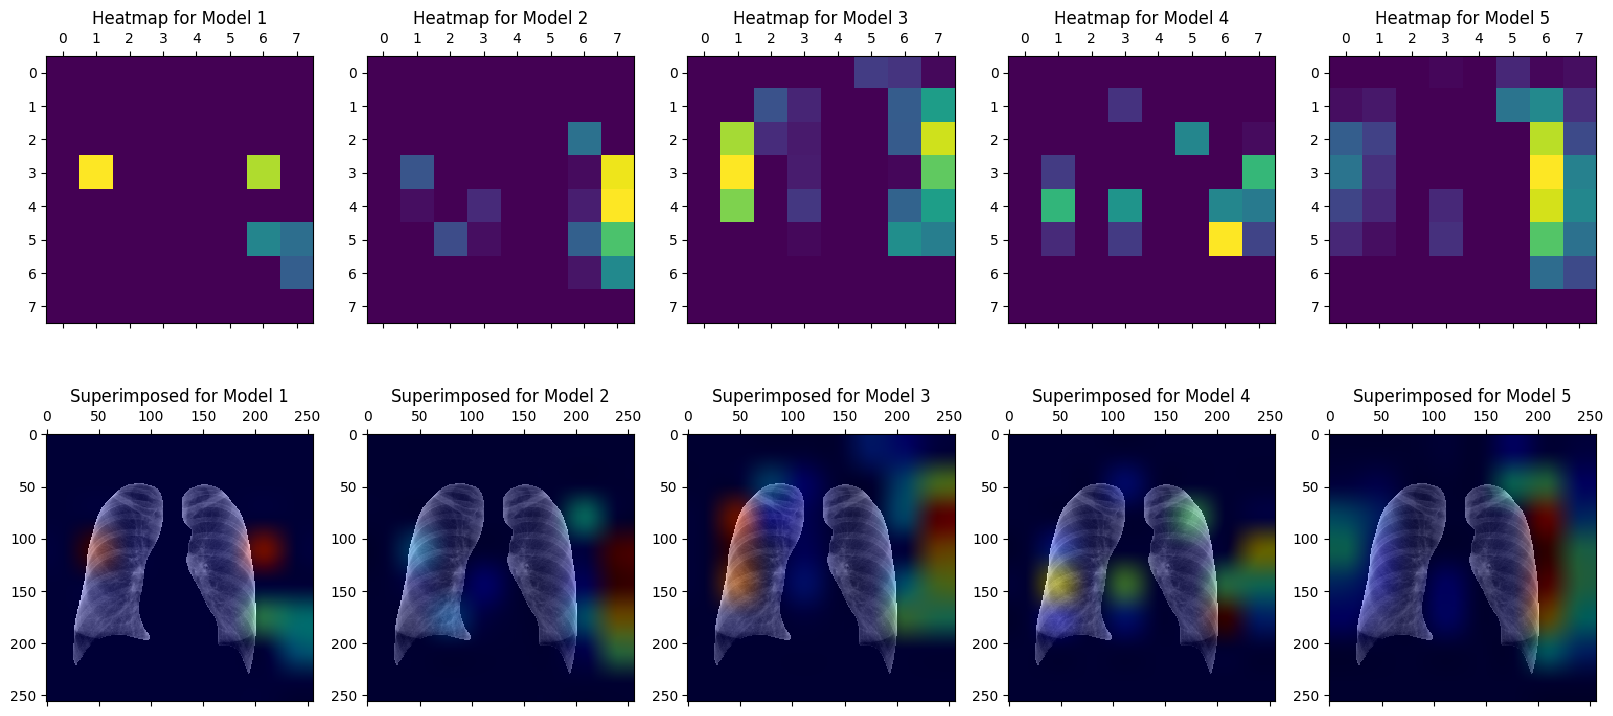

In [20]:
# ~~~~~~~~~~~~~~~~~~~~~ Evaluating ~~~~~~~~~~~~~~~~~~~~~
results = load_model.load_results(results_dir)

predictions = results['predictions']
y_true = results['y_true']
loss = results['loss']
val_loss = results['val_loss']

for pred in predictions:
    if len(pred) == 209:
        pred.append([0.0])

for t in y_true:
    if len(t) == 209:
        t.append([0.0])

y_true = np.array(y_true)
predictions = np.array(predictions)

visualize_confusion_matrices(predictions, y_true, title="Baseline Model On Segmented Dataset Confusion Matrices")
visualize_history_val_loss(loss, val_loss, title="Baseline Model On Segmented Dataset Epoch Loss")

samples = ['Tuberculosis', 'Normal']
for sample in samples:
    img_path = "./segmented_classification/overlayed_out/%s-16.png" % (sample)
    img_array = gradcam.get_img_array(img_path, size=(256, 256), color_mode='rgb')

    folds = len(predictions)
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 9))
    for i in range(folds):
        model = load_model.load_model('%s/%d-checkpoint.model.keras' % (ckpt_dir, i))
        model.layers[-1].activation = None

        heatmap = gradcam.make_gradcam_heatmap(img_array, model, layer_idx=9)
        ax[0, i].matshow(heatmap)
        ax[0, i].set_title('Heatmap for Model %d' % (i + 1))
        ax[1, i].matshow(gradcam.overlayed_gradcam(img_array[0], heatmap))
        ax[1, i].set_title('Superimposed for Model %d' % (i + 1))

    plt.show()

In [22]:
# ~~~~~~~~~~~~~~~~~~~~~ Training ~~~~~~~~~~~~~~~~~~~~~
def conv_layer(input, filters, kernel_size, **kwargs):
    x = keras.layers.Conv2D(filters, kernel_size, activation=None, **kwargs)(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(keras.activations.relu)(x)

    return x

def build_model():
    inputs = keras.Input(shape=(256, 256, 3))
    x = keras.layers.BatchNormalization()(inputs)
    x = conv_layer(x, 64, (3, 3), strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = conv_layer(x, 128, (3, 3), strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal())

    y = conv_layer(x, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 128, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())

    x = conv_layer(x, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.add([x, y])
    x = keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    y = conv_layer(x, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 128, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())

    x = conv_layer(x, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.add([x, y])

    x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = conv_layer(x, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(
        4096,
        activation=None,
        kernel_initializer=keras.initializers.GlorotNormal(),
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(keras.activations.relu)(x)

    x = keras.layers.Dense(
        4096,
        activation=None,
        kernel_initializer=keras.initializers.GlorotNormal(),
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(keras.activations.relu)(x)

    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001,
            beta_1=0.95
        ),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            'precision',
            'recall',
            keras.metrics.AUC()
        ]
    )

    return model

histories = []
predictions = []
y_true = []

ckpt_dir = 'models/residual_evaluation/ckpt'
results_dir = 'results/residual_evaluation'

crop = keras.layers.CenterCrop(256, 256)
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 1),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=10/11,
)

def apply_training_augment(images, labels):
    images = images / 255
    images = rand_augment(images)
    return images, labels

resize = keras.layers.Resizing(256, 256)
def apply_validation_normalisation(images, labels):
    return images / 255, labels

# This first if statement is to check if we already have the results
# for this model
if os.path.exists(os.path.join(results_dir, 'results.json')) == False:
    # If we do NOT have the results we need to ensure that we
    # remove the existing saved models before continuing
    if os.path.exists(ckpt_dir):
        shutil.rmtree(ckpt_dir)

    split, filenames, y = fold_segmented_classification(undersampling=True)
    for i, (train_idx, test_idx) in enumerate(split):
        # This block ensures that the epoch with the lowest validation loss
        # Is used for evaluation. While not perfect, it should be good enough
        # when using it over 5 folds.
        checkpoint_filepath = '%s/%d-checkpoint.model.keras' % (ckpt_dir, i)
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            start_from_epoch=5,
            restore_best_weights=True
        )
        tensorboard_cb = keras.callbacks.TensorBoard('tensorboard/classification/residual_evaluation/fold-%d' % i)

        train = filenames[train_idx]
        test = filenames[test_idx]
        copy_files_to_fold(train, test)

        # 10% of the test dataset will be used for validation
        train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/train',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            validation_split=0.1,
            subset='both',
            seed=42
        )

        train_dataset = train_dataset.map(apply_training_augment, num_parallel_calls=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        test_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/test',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            shuffle=False
        )
        test_dataset = test_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        model = build_model()
        history = model.fit(
            train_dataset,
            epochs=50,
            validation_data=validation_dataset,
            callbacks=[model_checkpoint_callback, early_stopping, tensorboard_cb]
        )

        histories.append(history)
        predictions.append(model.predict(test_dataset))
        y_true.append(np.concatenate([y for _, y in test_dataset], axis=0).astype(int))

    load_model.save_results(results_dir, histories, predictions, y_true)

Removing existing dataset
Copying train normal set...
Copying test normal set...
Copying train TB set...
Copying test TB set...
Found 836 files belonging to 2 classes.
Using 753 files for training.
Using 83 files for validation.
Found 210 files belonging to 2 classes.
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - accuracy: 0.5733 - auc_2: 0.6293 - loss: 0.9076 - precision: 0.5930 - recall: 0.5117 - val_accuracy: 0.5181 - val_auc_2: 0.6433 - val_loss: 0.6905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7063 - auc_2: 0.7521 - loss: 0.7780 - precision: 0.7117 - recall: 0.6991 - val_accuracy: 0.6265 - val_auc_2: 0.6895 - val_loss: 0.6892 - val_precision: 0.6957 - val_recall: 0.4000
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7588 - auc_2: 0.8198 - loss: 0.6091 - precision: 0.7719 - recall: 0.7476 - val_accuracy: 0.4819 - val_auc_2: 0.7035 - val_loss: 0.7500 - val_precision: 0.4819 - val_r

2024-08-31 19:44:19.589220: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 8 bytes spill stores, 8 bytes spill loads

2024-08-31 19:44:20.285204: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 176 bytes spill stores, 176 bytes spill loads

2024-08-31 19:44:20.396823: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_405', 620 bytes spill stores, 760 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step
Removing existing dataset
Copying train normal set...
Copying test normal set...
Copying train TB set...
Copying test TB set...
Found 837 files belonging to 2 classes.
Using 754 files for training.
Using 83 files for validation.


2024-08-31 19:44:21.269873: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 209 files belonging to 2 classes.
Epoch 1/50
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5691 - auc_3: 0.5939 - loss: 0.9389 - precision: 0.5635 - recall: 0.6087

2024-08-31 19:44:39.811308: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6467', 32 bytes spill stores, 32 bytes spill loads

2024-08-31 19:44:39.844078: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6467', 32 bytes spill stores, 32 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - accuracy: 0.5767 - auc_3: 0.6045 - loss: 0.9308 - precision: 0.5722 - recall: 0.6107 - val_accuracy: 0.4819 - val_auc_3: 0.7334 - val_loss: 0.6990 - val_precision: 0.4819 - val_recall: 1.0000
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6563 - auc_3: 0.7243 - loss: 0.7739 - precision: 0.6405 - recall: 0.6722 - val_accuracy: 0.6386 - val_auc_3: 0.7488 - val_loss: 0.6863 - val_precision: 0.5893 - val_recall: 0.8250
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.6964 - auc_3: 0.7541 - loss: 0.7978 - precision: 0.7041 - recall: 0.6786 - val_accuracy: 0.6867 - val_auc_3: 0.7686 - val_loss: 0.6716 - val_precision: 0.6944 - val_recall: 0.6250
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7030 - auc_3: 0.7598 - loss: 0.6950 - precision: 0.6919 - recall: 0.7189 - val_accuracy: 0.4819 - val_auc_3: 0.8122 - val_loss: 0.7203 - val_precision: 0.4819 - val_recall: 1.0000
Epoch 5/50
24/24 ━━━━━━━━━━

2024-08-31 19:47:26.371525: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 209 files belonging to 2 classes.
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 393ms/step - accuracy: 0.5568 - auc_4: 0.5848 - loss: 1.0783 - precision: 0.5547 - recall: 0.5813 - val_accuracy: 0.4819 - val_auc_4: 0.7503 - val_loss: 0.7182 - val_precision: 0.4819 - val_recall: 1.0000
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6694 - auc_4: 0.7334 - loss: 0.8196 - precision: 0.6566 - recall: 0.6869 - val_accuracy: 0.4819 - val_auc_4: 0.7305 - val_loss: 0.6916 - val_precision: 0.4819 - val_recall: 1.0000
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.7412 - auc_4: 0.8117 - loss: 0.5972 - precision: 0.7446 - recall: 0.7367 - val_accuracy: 0.5542 - val_auc_4: 0.6826 - val_loss: 0.6849 - val_precision: 0.5231 - val_recall: 0.8500
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.7256 - auc_4: 0.7723 - loss: 0.7149 - precision: 0.7124 - recall: 0.7429 - val_accuracy: 0.4819 - val_auc_4: 0.6733 - val_loss: 0.7117 - val_precision: 0.48

2024-08-31 19:54:02.770039: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 209 files belonging to 2 classes.
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.5729 - auc_6: 0.6065 - loss: 0.8625 - precision: 0.5976 - recall: 0.4427 - val_accuracy: 0.5181 - val_auc_6: 0.5666 - val_loss: 0.6917 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6827 - auc_6: 0.7475 - loss: 0.7296 - precision: 0.6707 - recall: 0.6821 - val_accuracy: 0.5181 - val_auc_6: 0.6672 - val_loss: 0.8099 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6765 - auc_6: 0.7606 - loss: 0.7455 - precision: 0.6600 - recall: 0.7358 - val_accuracy: 0.5181 - val_auc_6: 0.6041 - val_loss: 0.7077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7362 - auc_6: 0.8128 - loss: 0.6343 - precision: 0.7329 - recall: 0.7309 - val_accuracy: 0.4819 - val_auc_6: 0.7532 - val_loss: 0.7836

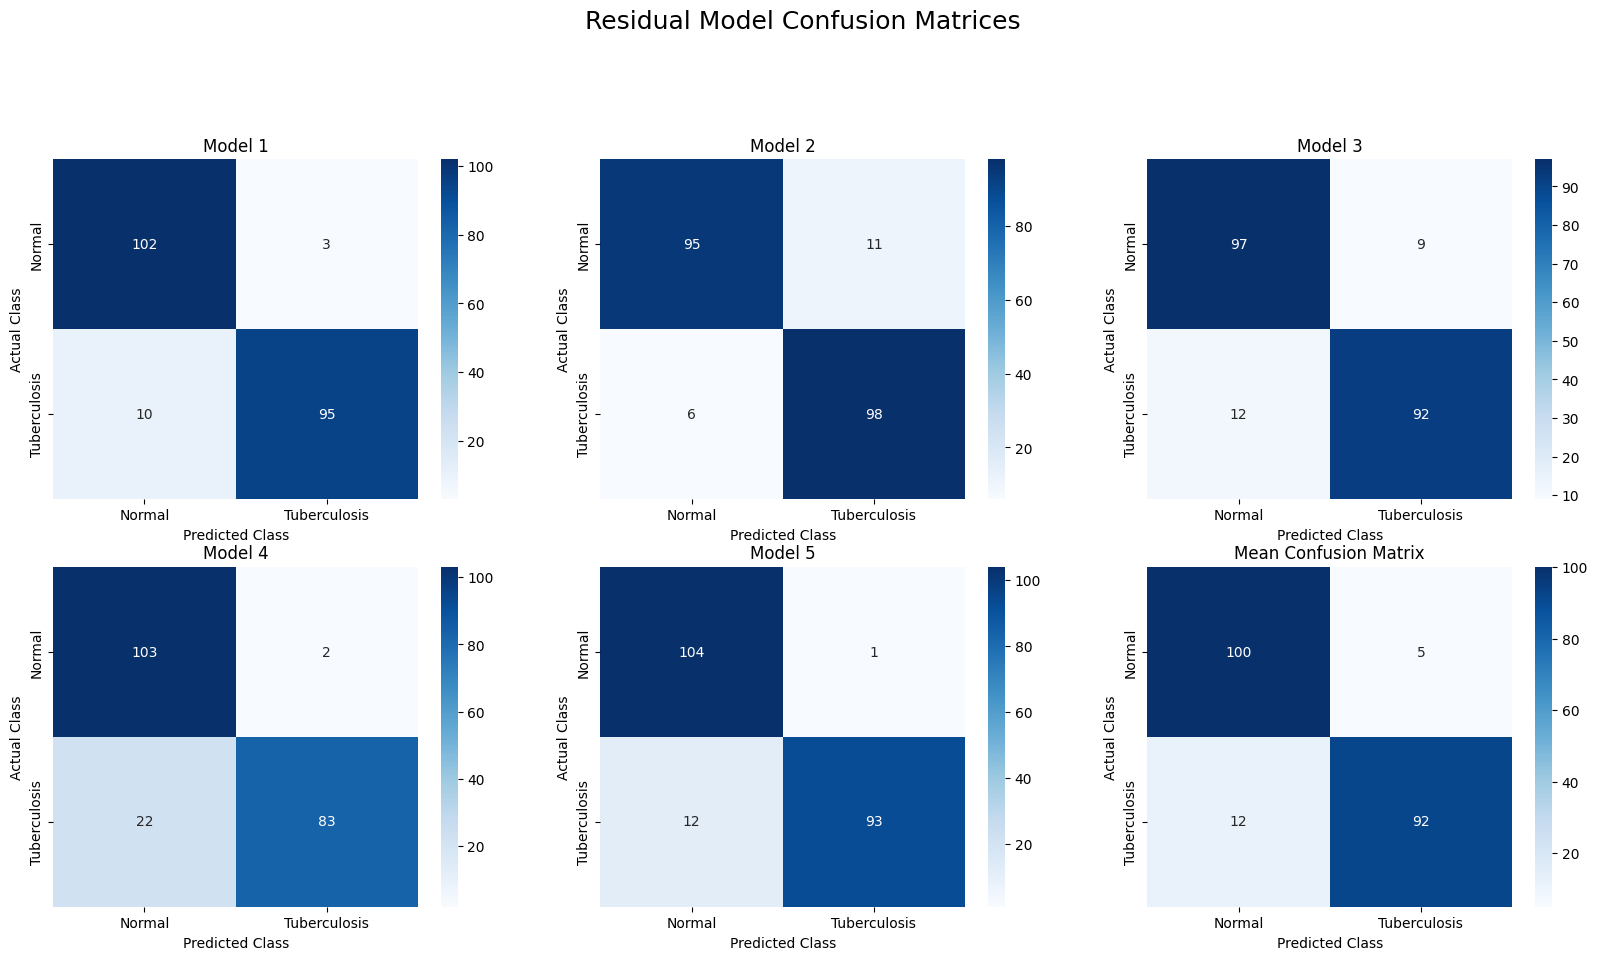

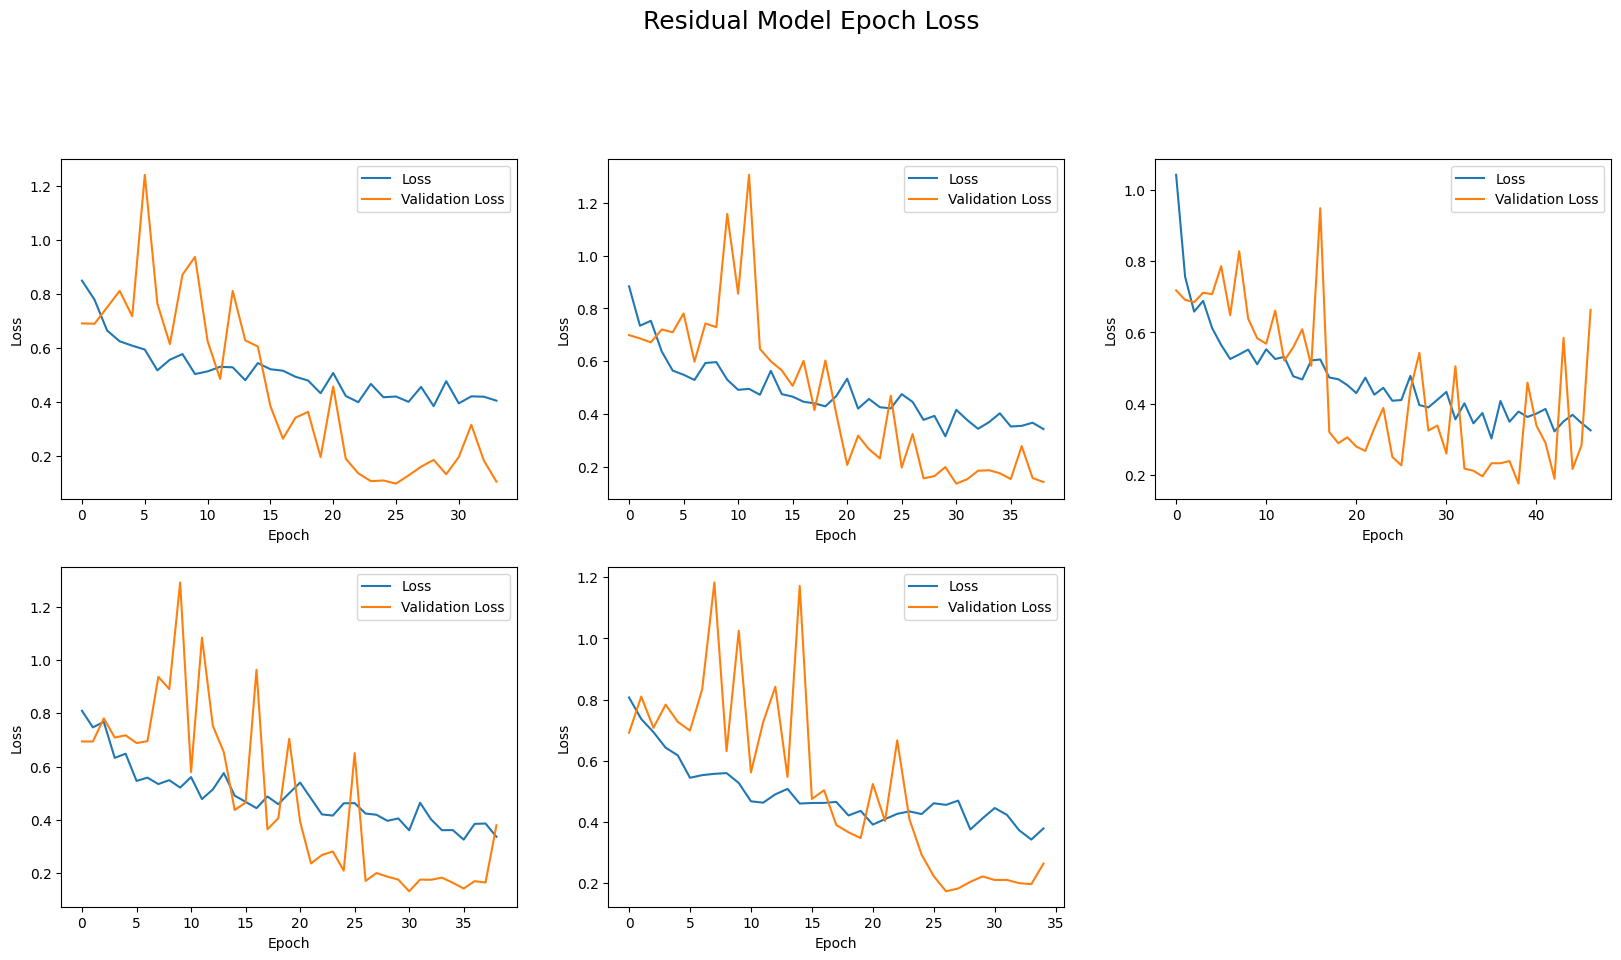

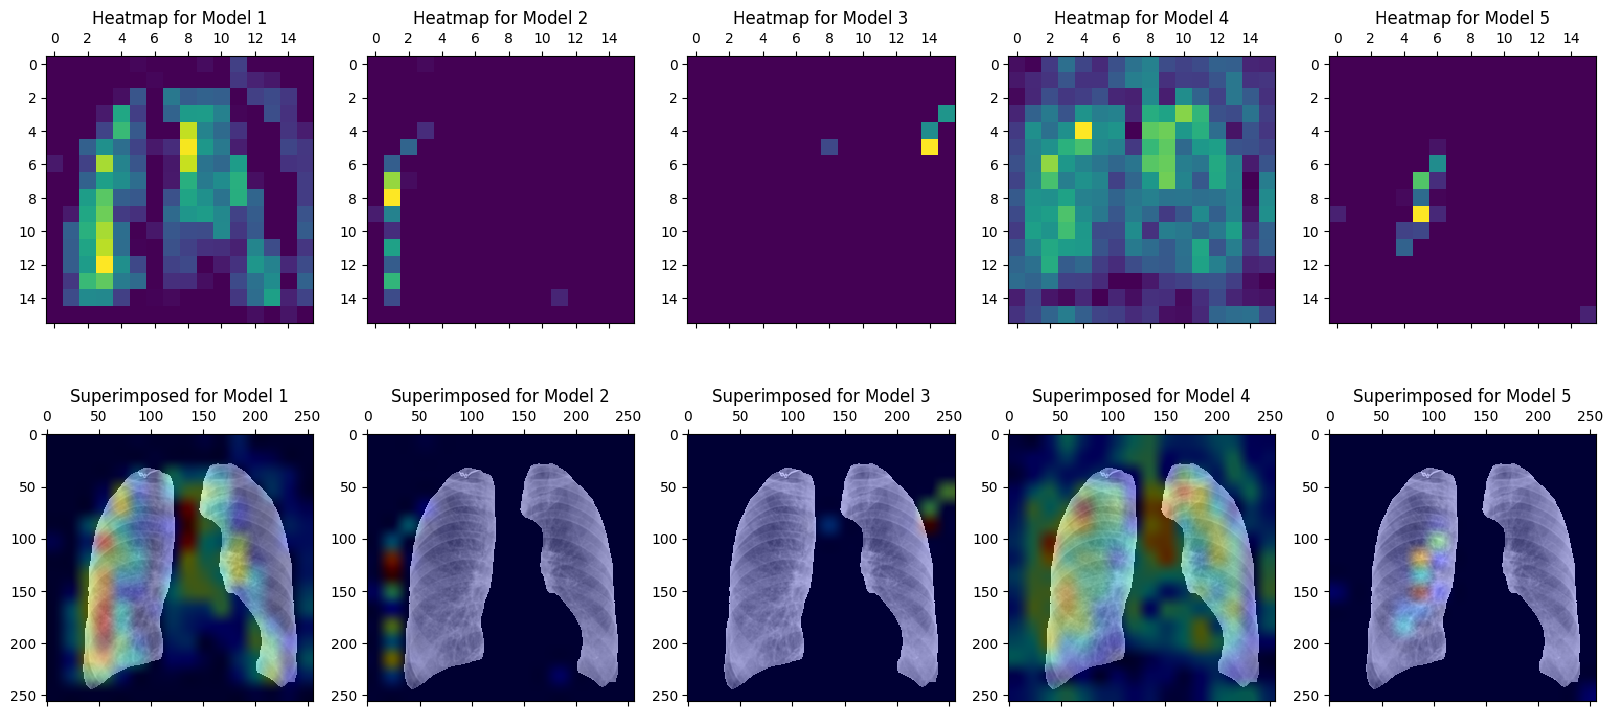

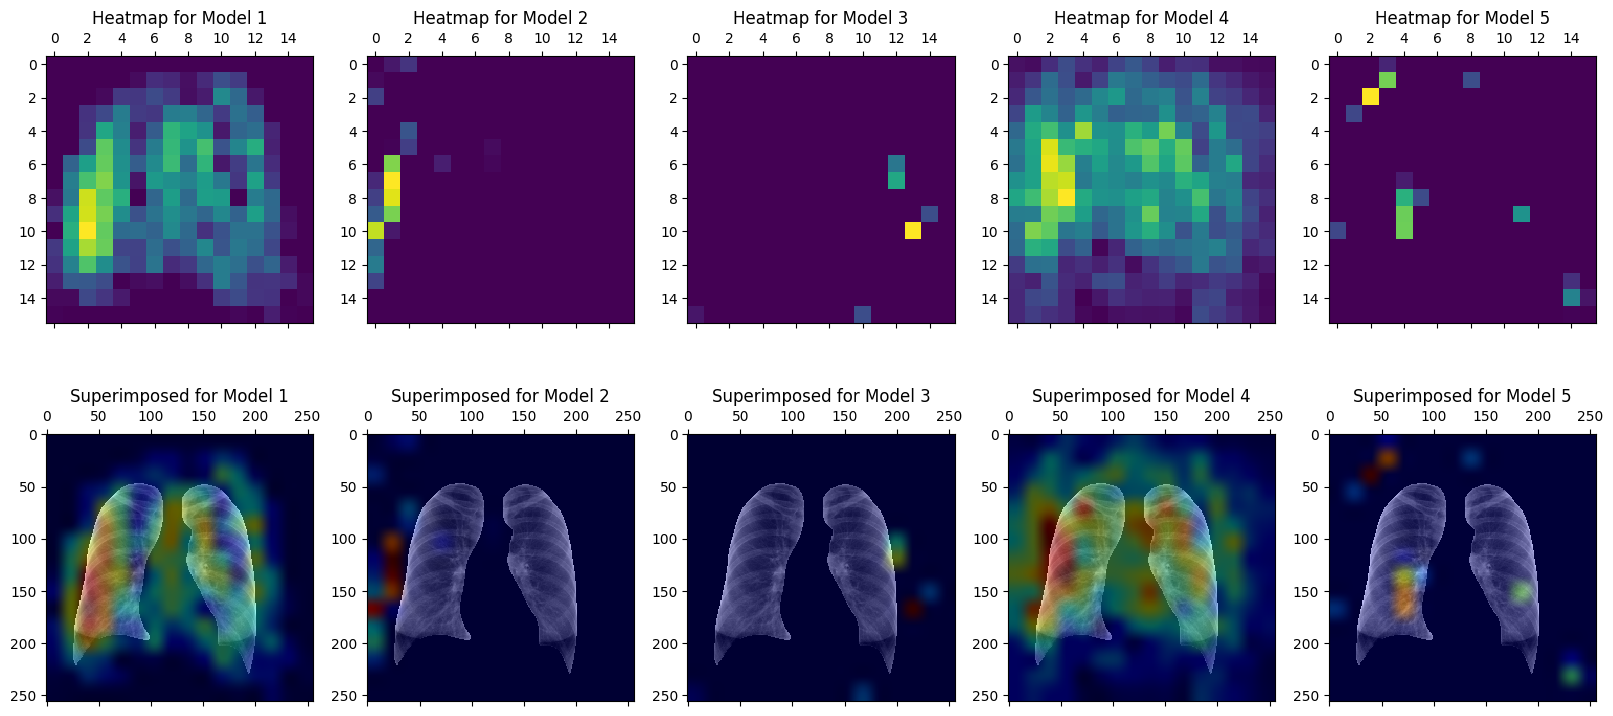

In [28]:
# ~~~~~~~~~~~~~~~~~~~~~ Evaluating ~~~~~~~~~~~~~~~~~~~~~
results = load_model.load_results(results_dir)

predictions = results['predictions']
y_true = results['y_true']
loss = results['loss']
val_loss = results['val_loss']

for pred in predictions:
    if len(pred) == 209:
        pred.append([0.0])

for t in y_true:
    if len(t) == 209:
        t.append([0.0])

y_true = np.array(y_true)
predictions = np.array(predictions)

visualize_confusion_matrices(predictions, y_true, title="Residual Model Confusion Matrices")
visualize_history_val_loss(loss, val_loss, title="Residual Model Epoch Loss")

samples = ['Tuberculosis', 'Normal']
for sample in samples:
    img_path = "./segmented_classification/overlayed_out/%s-16.png" % (sample)
    img_array = gradcam.get_img_array(img_path, size=(256, 256), color_mode='rgb')

    folds = len(predictions)
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 9))
    for i in range(folds):
        model = load_model.load_model('%s/%d-checkpoint.model.keras' % (ckpt_dir, i))
        model.layers[-1].activation = None

        heatmap = gradcam.make_gradcam_heatmap(img_array, model, layer_idx=-15)
        ax[0, i].matshow(heatmap)
        ax[0, i].set_title('Heatmap for Model %d' % (i + 1))
        ax[1, i].matshow(gradcam.overlayed_gradcam(img_array[0], heatmap))
        ax[1, i].set_title('Superimposed for Model %d' % (i + 1))

    plt.show()